# Nim Malware Analysis

From the malware analysis perspective, Nim has some fascinating characteristics.

## All Nim Windows Binaries Dynamically Resolve Their APIs
Let's perform an experiement.

In the `samples` directory, I have a number of malware samples. 

The first sample is a simple, four line C++ program that calls the ShellExecute API. Let's examine the code:

In [23]:
!cat ../samples/src/shellexec/cpp_shellexec/cpp_shellexec/cpp_shellexec.cpp

#include <iostream>
#include <windows.h>
#include <ShellApi.h>

int main()
{
    ShellExecute(0, L"open", L"notepad", L"", NULL, SW_SHOW);
}



The code is incredibly simple, but something interesting happens when this code is compiled. The compiler identifies the ShellExecute API in the code and links the required DLL and API into the binary's Import Address Table (IAT). The IAT acts as a phone book for the API calls that a binary uses during execution.

When this C++ program is compiled and examined, its IAT includes the ShellExec API call:

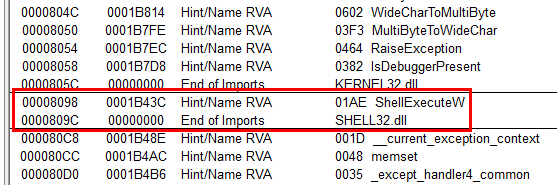

This can inform malware analysts very quickly about the existence of malicious code in a binary.

In the `src` directory of this notebook, I've included a copy of `MalAPIReader`, a collaboration between myself, [@SquiblydooBlog](https://twitter.com/SquiblydooBlog) and [mrd0x](https://twitter.com/mrd0x). This program is a Python script that pulls the Import Address Table out from a portable executable and checks each Windows API call against https://malapi.io. This helps to find API calls that are commonly used by malware.

We will use `MalAPIReader` with two different PEs in this directory and compare the difference. First, let's examine this C++ program.


In [20]:
!python3 ../src/MalAPIReader/MalAPIReader.py --pe ../samples/shellexec/cpp_shellexec.exe

---------------MalAPIReader.py---------------
Hit: ShellExecuteA
Hit: TerminateProcess
Hit: GetCurrentProcess
Hit: GetProcAddress
Hit: GetProcessHeap
Hit: HeapAlloc
Hit: GetModuleHandleA
Hit: GetCurrentThreadId
Hit: GetSystemTimeAsFileTime
Hit: GetCurrentProcessId
Hit: QueryPerformanceCounter
Hit: IsDebuggerPresent
Sample: ../samples/shellexec/cpp_shellexec.exe

ShellExecuteA
    \\---> ShellExecuteA is used to perform an operation on a specified file.
TerminateProcess
    \\---> TerminateProcess is used to terminate a process.
GetCurrentProcess
    \\---> GetCurrentProcess is used to retrieve a handle for the current process.
GetProcAddress
    \\---> GetProcAddress is used to get the memory address of a function in a DLL. This is often used by malware for obfuscation and evasion purposes to avoid having to call the function directly.
GetProcessHeap
    \\---> GetProcessHeap is used to retrieve a handle to the default heap of the calling process.
HeapAlloc
    \\---> HeapAlloc is used

---
The MalAPIReader script should have identified `ShellExecute`, a Win API that is commonly used to interact with files. We can then examine this API call and its parameters to identify 

---
## [Previous: A Brief History of Nim](HistoryOfNim.ipynb) ||--0--|| [Next: Nim's Offensive Applications](OffensiveNim.ipynb)

This is a picture from the VirusTotal page for SikoMode, one of the PMAT challenge binaries written in Nim.

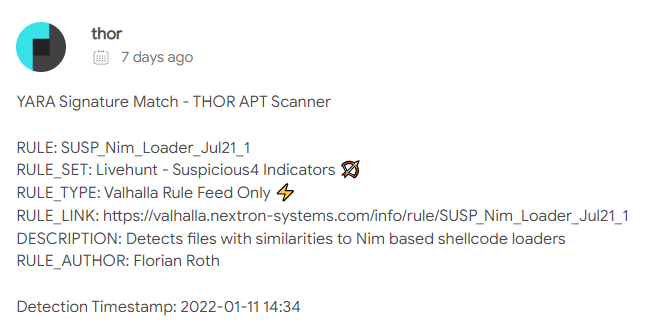